In [73]:
%matplotlib inline

import matplotlib.pyplot as plt
import csv
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

df = pd.read_csv('data/olympic-country-medals-with-indicators.csv')
df.head()

,olympic_id,year,available_medals,country_abv,country,olympic_medals,olympic_medal_percentage,prev_olympic_medals,prev_olympic_medal_percentage,host_nation,...,region_advantage,gdp,income_group,income_group_id,population,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23
0,15,1960,144,ARG,Argentina,2,0.0139,NaN,NaN,ITA,...,0,NaN,Not classified,0,20619075,NaN,NaN,NaN,NaN,NaN
1,15,1960,144,AUS,Australia,22,0.1528,NaN,NaN,ITA,...,0,1.856759e+10,High income,4,10276477,NaN,NaN,NaN,NaN,NaN
2,15,1960,144,AUT,Austria,2,0.0139,NaN,NaN,ITA,...,1,6.592694e+09,High income,4,7047539,NaN,NaN,NaN,NaN,NaN
3,15,1960,144,BEL,Belgium,4,0.0278,NaN,NaN,ITA,...,1,1.165872e+10,High income,4,9153489,NaN,NaN,NaN,NaN,NaN
4,15,1960,144,BRA,Brazil,2,0.0139,NaN,NaN,ITA,...,0,1.516557e+10,Upper middle income,3,72493585,NaN,NaN,NaN,NaN,NaN


## Data Exploration
Let's take a quick look at some of the features to get a sense of what should be included in our model.

In [74]:
df['gdp_per_cap'] = df['gdp']/df['population']
print df['gdp_per_cap'][:4]

0            NaN
1    1806.804876
2     935.460427
3    1273.691659
Name: gdp_per_cap, dtype: float64


<function matplotlib.pyplot.show>

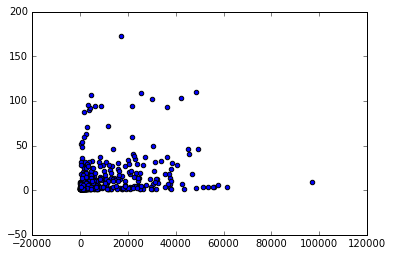

In [76]:
plt.scatter(df['gdp_per_cap'], df['olympic_medals'])
plt.show

The scatter plot of GDP per Capita by Medal Count does not show a strong correlation. 

Full GDP might.

<function matplotlib.pyplot.show>

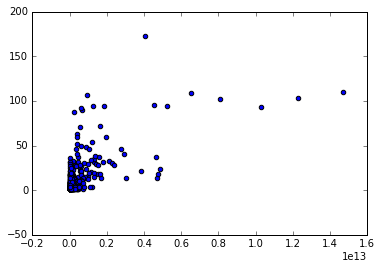

In [78]:
plt.scatter(df['gdp'], df['olympic_medals'])
plt.show

GDP has a stronger coorelation than GDP per Capita. I believe this is because GDP is linked to Population. The higher the population, the more wealth a country can produce and also the country has a bigger pool of athletes to select from for the Olympics.

Let us next take a look at GDP by Population and how Population might coorelate to Olympic Medals.

<function matplotlib.pyplot.show>

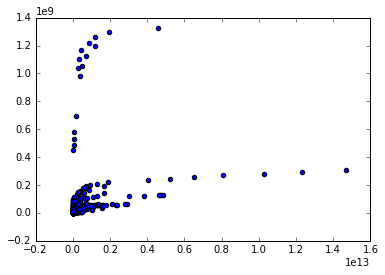

In [68]:
plt.scatter(df['gdp'], df['population'])
plt.show

On the x-axis we have GDP and on the y-axis is population. This is showing us that population does not necessarily mean the country will generate more wealth. The population's of India and China are stretching the y-axis. 

<function matplotlib.pyplot.show>

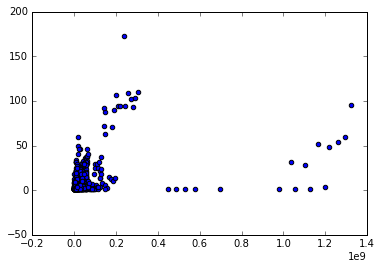

In [69]:
plt.scatter(df['population'], df['olympic_medals'])
plt.show

Population by Olympic Medals does show some coorelation, but is again being strung out by India and China.

Population does not look to be as strong an indicator as GDP. GDP measures Population to an extenet and also somewhat measures how much money the athletes have access to for training. GDP seems to be our best predictor so far.

<function matplotlib.pyplot.show>

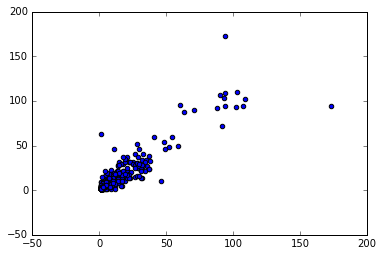

In [81]:
plt.scatter(df['prev_olympic_medals'], df['olympic_medals'])
plt.show

Now __this is interesting!__ There is a strong coorelation between a country's previous Olympic performance and how they did in the next Olympics.

The Olympics are always growing though! More events are added, which means more medals are awarded. It would be more accurate to compare percentage of medals won. 

<function matplotlib.pyplot.show>

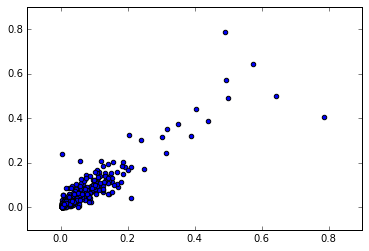

In [83]:
plt.scatter(df['prev_olympic_medal_percentage'], df['olympic_medal_percentage'])
plt.show

Comparing percentages tightens our coorelation up even more and allows us to pass a "Number of Events" predictor into our model. 

## Build the model
After our data exploration we are ready to build and test some models. I think GDP and Previous Olympic Medal performance are going to be the two best indicators to use.

In [133]:
def country_regression(country_abv):
    country_df = df[df.country_abv == country_abv]
    formula = 'olympic_medals ~ available_medals + prev_olympic_medal_percentage + gdp + region_advantage'

    return smf.ols(formula=formula, data=country_df).fit()

usa = country_regression('CAN')
usa.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         olympic_medals   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     1.610
Date:                Sun, 04 Sep 2016   Prob (F-statistic):              0.287
Time:                        20:24:09   Log-Likelihood:                -38.253
No. Observations:                  11   AIC:                             86.51
Df Residuals:                       6   BIC:                             88.50
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------
Intercept                        -5.9286     28.088     -0.211      0.840       -74.658    62.801
available_medals                  0.0631      0.164      0.385      0.714        -0.338     0.464
prev_olympic_medal_percentage     6.6216     67.607      0.098      0.925      -158.808   172.051
gdp                            2.635e-12   1.79e-11      0.147      0.888     -4.11e-11  4.64e-11
region_advantage                 16.6894      7.520      2.219      0.068        -1.712    35.091
==============================================================================
Omnibus:                        8.116   Durbin-Watson:                   2.923
Prob(Omnibus):                  0.017   Jarque-Bera (JB):                3.434
Skew:                           1.109   Prob(JB):                        0.180
Kurtosis:                       4.605   Cond. No.                     1.46e+13
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.46e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [101]:
from sklearn.cross_validation import KFold

country_df = df[df.country_abv == 'USA']
X = country_df[['available_medals', 'prev_olympic_medal_percentage', 'gdp', 'host_advantage', 'region_advantage']]
y = country_df.olympic_medals
kf = KFold(5, n_folds=2)

for train_index, test_index in kf:
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

('TRAIN:', array([3, 4]), 'TEST:', array([0, 1, 2]))
('TRAIN:', array([0, 1, 2]), 'TEST:', array([3, 4]))


In [71]:
year = 1960
df.loc[df.country_abv == 'USA', ['year','gdp']]

,year,gdp
28,1960,5.430000e+11
59,1964,6.860000e+11
90,1968,9.430000e+11
125,1972,1.280000e+12
152,1976,1.880000e+12
214,1984,4.040000e+12
252,1988,5.250000e+12
295,1992,6.540000e+12
346,1996,8.100000e+12
402,2000,1.030000e+13


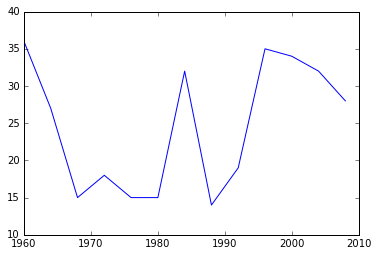

In [25]:
italy_results = df[df.country_abv == 'ITA']

plt.plot(italy_results.year, italy_results.olympic_medals)